# Audio Unit Selection Model - 03 Sequence Modelling 

In [1]:
import os
import warnings
import pickle as pkl
from time import time
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

import librosa

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

from tqdm.auto import tqdm
from IPython.display import Audio, display

from models import EmbeddedTransformerModel, LinearAE

In [2]:
plt.rcParams['figure.figsize'] = (10, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('computing on', device)

computing on cuda


### Load data

In [5]:
with open('./data/test_music/unit_features.pkl', 'rb') as f:
    unit_features = pkl.load(f)
    
feature_tensors = torch.stack([torch.tensor(x, dtype=torch.float) for x in unit_features])

with open('./data/test_music/sequences.pkl', 'rb') as f:
    sequences = pkl.load(f)

In [6]:
# set the first element to the END_LOOP token
feature_tensors[0] = 0

In [7]:
max([len(s) for s in sequences])

35

In [8]:
MAX_LEN = 32

### Make Embeddings 

In [9]:
embedding_parameters = torch.load(f'models/AE_embedding_model.pt')
embedding_model = LinearAE(**embedding_parameters['model_params']).to(device)
embedded = embedding_model.encode(feature_tensors.to(device)).detach()

print(embedded.shape)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [8]:
embedding_size = embedded.shape[1]

### Make Training Data Sequences 

In [9]:
# sequence_tensor: (num_sequences, MAX_LEN, embedding_size)
# padded with END_LOOP token (all zeros)

st = []

for i, s in enumerate(sequences):
    if len(s) <= 1:
        continue
    seq = torch.zeros((MAX_LEN, embedding_size))
    seq[:min(len(s), MAX_LEN), :] = torch.stack([embedded[u] for u in s][:MAX_LEN])
    st.append(seq)
    
sequence_tensor = torch.stack(st).detach().to(device)
print(sequence_tensor.shape)

torch.Size([3984, 32, 16])


In [10]:
BATCH_SIZE = 24

In [11]:
dataset = DataLoader(sequence_tensor, BATCH_SIZE, shuffle=True, drop_last=True)

In [12]:
train_number = int(0.7 * len(dataset))
test_number = len(dataset) - train_number

train_data, test_data = random_split(dataset, [train_number, test_number])

### Model Init 

In [13]:
import models
reload(models)
from models import EmbeddedTransformerModel

In [14]:
model_params = {
    'ninp': embedding_size,
    'nhead': 4,
    'nhid': 64,
    'nlayers': 4,
    'dropout': 0.3
}

In [15]:
sequence_model = EmbeddedTransformerModel(**model_params).to(device)

### Training 

In [16]:
import training
reload(training)
from training import trainTransformer, evaluateTransformer

In [17]:
criterion = nn.MSELoss()
lr = 0.0001
optimiser = torch.optim.Adam(sequence_model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, 1.0, gamma=0.99)

In [18]:
EPOCHS = 10

In [19]:
train_losses = []
val_losses = []
epoch = 0

#### Load Previous Model 

In [20]:
try:
    parameters = torch.load(f'models/sequence_model.pt')

    sequence_model = EmbeddedTransformerModel(**parameters['model_params']).to(device)

    sequence_model.load_state_dict(parameters['model_state_dict'])
    optimiser.load_state_dict(parameters['optimiser_state_dict'])
#     scheduler.load_state_dict(parameters['scheduler_state_dict'])

    train_losses = parameters['train_losses']
    val_losses = parameters['val_losses']
    epoch = parameters['epoch']
    print('loaded previous model, continuing training')
except FileNotFoundError:
    print('/!\\ Parameters not found, first model run?')

loaded previous model, continuing training


#### Run Training 

In [26]:
for i in range(1, EPOCHS+1):
    epoch += 1
    print(' == Epoch {:3d}   ({} of {})'.format(epoch, i, EPOCHS))
    epoch_start = time()
    loss, batch_losses = trainTransformer(sequence_model, train_data, optimiser, criterion, device,
                                          debug=False, update=10)
    train_losses.extend(batch_losses)
    
    val_loss = evaluateTransformer(sequence_model, test_data, criterion)
    val_losses.append(val_loss)

    print('    time {}s | Train Loss {:.3f} | Validation Loss {:5.3f} | lr {:.4f}x10^-4'.format(
        int(time() - epoch_start), loss, val_loss, lr*10000))

 == Epoch  31   (1 of 10)
    time 1s | Train Loss 0.033 | Validation Loss 0.030 | lr 1.0000x10^-4
 == Epoch  32   (2 of 10)
    time 1s | Train Loss 0.029 | Validation Loss 0.027 | lr 1.0000x10^-4
 == Epoch  33   (3 of 10)
    time 1s | Train Loss 0.026 | Validation Loss 0.024 | lr 1.0000x10^-4
 == Epoch  34   (4 of 10)
    time 1s | Train Loss 0.024 | Validation Loss 0.022 | lr 1.0000x10^-4
 == Epoch  35   (5 of 10)
    time 1s | Train Loss 0.021 | Validation Loss 0.020 | lr 1.0000x10^-4
 == Epoch  36   (6 of 10)
    time 1s | Train Loss 0.020 | Validation Loss 0.018 | lr 1.0000x10^-4
 == Epoch  37   (7 of 10)
    time 1s | Train Loss 0.018 | Validation Loss 0.017 | lr 1.0000x10^-4
 == Epoch  38   (8 of 10)
    time 1s | Train Loss 0.017 | Validation Loss 0.016 | lr 1.0000x10^-4
 == Epoch  39   (9 of 10)
    time 1s | Train Loss 0.017 | Validation Loss 0.016 | lr 1.0000x10^-4
 == Epoch  40   (10 of 10)
    time 1s | Train Loss 0.016 | Validation Loss 0.015 | lr 1.0000x10^-4


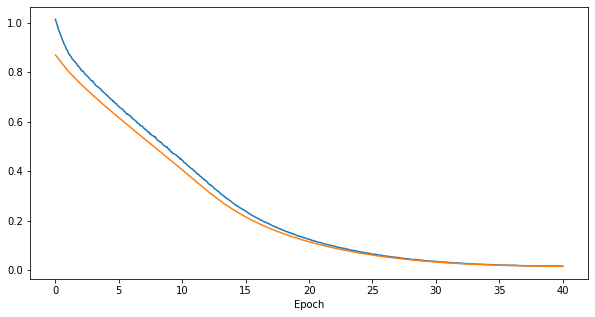

In [27]:
plt.plot(np.linspace(0, epoch, len(train_losses)), train_losses)
plt.plot(np.linspace(0, epoch, len(val_losses)), val_losses)
plt.xlabel('Epoch')
plt.show()

In [28]:
torch.save({
    'model_state_dict': sequence_model.state_dict(),
    'model_params': model_params,
    'optimiser_state_dict': optimiser.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epoch,
    'train_losses': train_losses,
    'val_losses': val_losses,
}, f'models/sequence_model.pt')

### Make Predictions 

In [21]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances 

from IPython.display import display, Audio

In [22]:
with open('./data/units.pkl', 'rb') as f:
    units = pkl.load(f)

In [83]:
for b in test_data.dataset:
    break

In [175]:
b.shape

torch.Size([24, 32, 16])

In [85]:
_ = sequence_model.eval()

In [127]:
output = sequence_model(b[0, :1])

In [176]:
output.shape

torch.Size([1, 16])

In [129]:
embedded.shape

torch.Size([52538, 16])

In [130]:
n = output[0, :1]

In [131]:
n.shape

torch.Size([1, 16])

In [132]:
dist = euclidean_distances(embedded.cpu().detach(), n.cpu().detach(), squared=True)

In [133]:
dist.argmin(), dist.min()

(5584, 0.053888004)

In [135]:
sim = cosine_similarity(embedded.cpu().detach(), n.cpu().detach())

In [136]:
sim.argmax(), sim.max()

(42685, 0.9820404)

In [123]:
units[42685]

array([-0.3171234 , -0.30162048, -0.28622437, ...,  0.18579102,
        0.18914795,  0.18992615], dtype=float32)

In [77]:
predicted_idxs = [np.random.randint(len(embedded))]
seed = torch.stack([embedded[i] for i in predicted_idxs]).unsqueeze(1)
print(seed.shape)
for i in range(15):
    output = sequence_model(seed)[0, -1:]
    distance = euclidean_distances(embedded.cpu().detach(), output.cpu().detach())

    predicted_idx = distance.argmin()
    
    predicted_idxs.append(predicted_idx)
    predicted_embedding = embedded[predicted_idx].unsqueeze(0)
    
    seed = torch.stack([embedded[i] for i in predicted_idxs]).unsqueeze(1)
    
    print(seed.shape, predicted_idx)

torch.Size([1, 1, 16])
torch.Size([2, 1, 16]) 33479
torch.Size([3, 1, 16]) 33479
torch.Size([4, 1, 16]) 33479
torch.Size([5, 1, 16]) 33479
torch.Size([6, 1, 16]) 33479
torch.Size([7, 1, 16]) 33479
torch.Size([8, 1, 16]) 33479
torch.Size([9, 1, 16]) 33479
torch.Size([10, 1, 16]) 33479
torch.Size([11, 1, 16]) 33479
torch.Size([12, 1, 16]) 26283
torch.Size([13, 1, 16]) 51774
torch.Size([14, 1, 16]) 16604
torch.Size([15, 1, 16]) 51774
torch.Size([16, 1, 16]) 8910


In [78]:
unit_audio = [units[i] for i in predicted_idxs]
audio = np.concatenate(unit_audio)

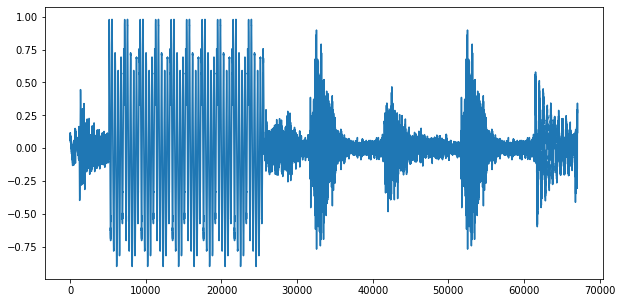

In [79]:
plt.plot(audio)
plt.show()

In [80]:
display(Audio(data=np.tile(audio, 4), rate=44100))

In [46]:
for ua in unit_audio:
    display(Audio(data=ua, rate=44100))

#### using Teoniki's samples

In [85]:
with open('./data/lawki_now/unit_features.pkl', 'rb') as f:
    teo_unit_features = pkl.load(f)
    
with open('./data/lawki_now/fps.pkl', 'rb') as f:
    fps = pkl.load(f)

In [87]:
teo_feature_tensors = torch.stack([torch.tensor(x, dtype=torch.float) for x in teo_unit_features])

In [90]:
teo_embedded = embedding_model.encode(teo_feature_tensors.to(device)).detach()

In [95]:
teo_audio_units = [librosa.load(fp, None) for fp in tqdm(fps)]

In [96]:
teo_embedded.shape, len(teo_audio_units)

(torch.Size([376, 16]), 376)

In [ ]:
predicted_idxs = [np.random.randint(len(embedded))]
seed = torch.stack([embedded[i] for i in predicted_idxs]).unsqueeze(1)
print(seed.shape)
for i in range(15):
    output = sequence_model(seed)[0, -1:]
    distance = euclidean_distances(embedded.cpu().detach(), output.cpu().detach())

    predicted_idx = distance.argmin()
    
    predicted_idxs.append(predicted_idx)
    predicted_embedding = embedded[predicted_idx].unsqueeze(0)
    
    seed = torch.stack([embedded[i] for i in predicted_idxs]).unsqueeze(1)
    
    print(seed.shape, predicted_idx)